## Backtesting an Algo Trading strategy based on Linear Regression

#### Import the modules

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import yfinance as yf
import seaborn as sns
today=datetime.today().strftime("%Y-%m-%d")
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

data=pd.DataFrame(yf.download("MSFT", start="2021-01-01", end = today, parse_dates=True)["Adj Close"])
data

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2020-12-31,219.604492
2021-01-04,214.934357
2021-01-05,215.141693
2021-01-06,209.563217
2021-01-07,215.526764
...,...
2022-06-27,264.890015
2022-06-28,256.480011
2022-06-29,260.260010


#### Define a automated function

In [55]:
class LinearRegression_Backtester(object):
    
    def __init__(self, ticker, start, end, notional, costs, lags):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.notional = notional
        self.costs = costs
        self.results = None
        self.lags = lags
        self.get_data()
    
    def get_data(self):
#We get the data from yahoo finance and we prepare the data by getting the relevant columns.
        data = pd.DataFrame(yf.download(self.ticker, start=self.start, end = self.end, parse_dates=True)["Adj Close"])
        data.rename(columns={self.ticker: "Price {}".format(self.ticker)}, inplace=True)
        data["returns"]=data.pct_change()
        #data["annualized_returns"]=np.sum((data["returns"].mean()*pct)*252)
        self.data = data#.dropna(inplace=True)
        return data

    def get_lags(self, start, end):
# We prepare the final data with the desired number of lags for regression.
        data = self.data
        self.cols = []
        for lag in range(1, self.lags + 1):
            col = "lag_{}".format(lag)
            data[col] = data["returns"].shift(lag)
            self.cols.append(col)
            data.dropna(inplace=True)
            self.data_final = data
        
    def fit_model(self, start, end):
#Implementation of the Linear regression, we get the slope coefficient (coefficient directeur) and the intercept (ordonnée à l'origine)
        self.get_lags(start, end)
        ls_coefficients = np.linalg.lstsq(self.data_final[self.cols],np.sign(self.data_final["returns"]),rcond=None)[0]
        self.coefficients = ls_coefficients
    
    def run_strategy(self, start_train, end_train, start_strategy, end_strategy,lags=None):
# We Backtest the Linear Regression strategy.
        #self.lags = lags
        self.fit_model(start_train, end_train)
        self.results = self.get_data()
        self.get_lags(start_strategy, end_strategy)
        prediction = np.sign(np.dot(self.data_final[self.cols], self.coefficients))
        self.results["prediction"] = prediction
        self.results["strategy"] = self.results["prediction"] * self.results["returns"]
    
# We determine when a trade takes place by pointing out when the difference between two successives values isn't null.
        trades = self.results["prediction"].diff().fillna(0) != 0
    
 # We subtract the trading costs from return when the trade takes occurs
        self.results["strategy"][trades] -= self.costs
        self.results["cum_returns"] = self.notional * self.results["returns"].cumsum().apply(np.exp)
        self.results["cum_strategy"] = self.notional * self.results["strategy"].cumsum().apply(np.exp)
        
 # The performance of the strategy at maturity (the end of the trading period)
        perf = self.results["cum_strategy"].iloc[-1]
    
 # The performance of the strategy with respect to the normal returns
        perf_comparison = perf - self.results["cum_returns"].iloc[-1]
        return round(perf, 2), round(perf_comparison, 2)
    
    def plot_results(self):
#We plot the cumulative returns of the historical data and our elaborated linear regression strategy  
        title = "{} performance, with a cost of {}$/trade".format(self.ticker, self.costs)
        self.results[["cum_returns", "cum_strategy"]].plot(title=title)
        

#### Test the function and verify the results

In [57]:
#Strategy with no trading costs
lr_free=LinearRegression_Backtester("MSFT", "2014-1-1", "2022-06-30",10000, 0.0, lags=3)
lr_free.run_strategy("2010-1-1", "2012-12-31","2010-1-1", "2022-06-30")  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(63397.07, -52808.4)

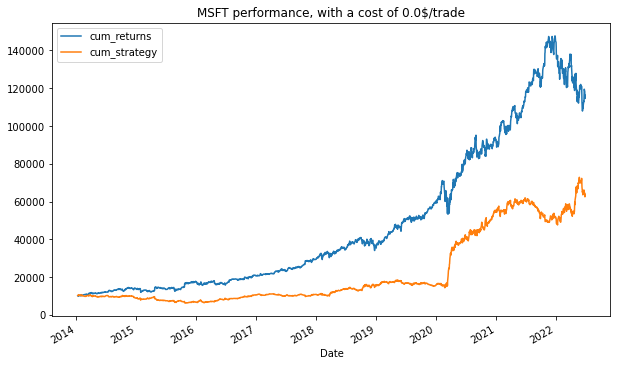

In [49]:
lr_free.plot_results()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


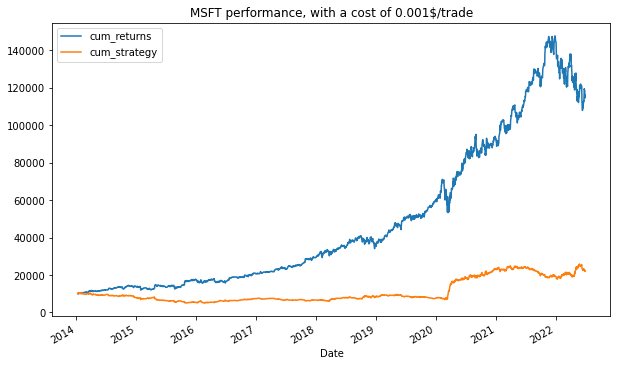

In [58]:
#Strategy with included trading costs
lr_costly=LinearRegression_Backtester("MSFT", "2014-1-1", "2022-06-30",10000, 0.001, lags=3)
lr_costly.run_strategy("2010-1-1", "2012-12-31","2010-1-1", "2022-06-30") 
lr_costly.plot_results()